In [2]:
import numpy as np

In [3]:
# Dense Layer
class Layer_Dense:
    def __init__(self,n_inputs,n_neurons,
                 weight_regularizer_l1 = 0,weight_regularizer_l2=0,
                 bias_regularizer_l1 = 0, bias_regularizer_l2 = 0):
        # init of weights and bias
        self.weights = 0.01 * np.random.randn(n_inputs,n_neurons)
        self.biases = np.zeros((1,n_neurons))
        # init the regularization
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
        
        
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights) + self.biases
        
    def backward(self,dvalues):
        # calculating gradients for parameters
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        
        # calculating gradients for regularization
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases 
            
        # gradients on whole values
        self.dinputs = np.dot(dvalues,self.weights.T)

In [4]:
class Activation_RELU:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
        
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [5]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    def post_update_params(self):
        self.iterations += 1

In [6]:
class Loss:
    def regularization_loss(self,layer):
        regularization_loss = 0
        # Weight Loss
        if layer.weight_regularizer_l1 > 0:
            # sum of absolute values of weights
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if layer.weight_regularizer_l2 > 0:
            # sum of squared values of weights
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
            
        return regularization_loss
    
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss

# Linear Regression

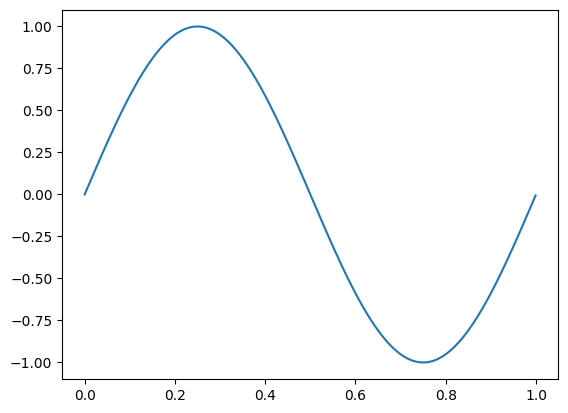

In [1]:
import nnfs
from nnfs.datasets import sine_data
import matplotlib.pyplot as plt

nnfs.init()

X,y = sine_data()

plt.plot(X,y)
plt.show()

In [7]:
class Activation_Linear:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = inputs
        
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()

In [8]:
class Loss_MeanSquaredError(Loss):
    def forward(self,y_pred,y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred),axis=-1)
        return sample_losses
    
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

In [13]:
dense1 = Layer_Dense(1,64)
activation1 = Activation_RELU()
dense2 = Layer_Dense(64,64)
activation2 = Activation_RELU()
dense3 = Layer_Dense(64,1)
activation3 = Activation_Linear()
loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_Adam(learning_rate=0.005,decay=1e-3)

In [14]:
epoches = []
losses = []
data_losses = []
reg_losses = []

In [15]:
from tqdm import tqdm

for epoch in tqdm(range(10001),desc="Training the model"):
    # forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    
    data_loss = loss_function.calculate(activation3.output,y)
    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2) + loss_function.regularization_loss(dense3)
    loss = data_loss + regularization_loss
    
    if not epoch % 100:
        epoches.append(epoch)
        losses.append(loss)
        data_losses.append(data_loss)
        reg_losses.append(regularization_loss)
        
    # backward pass
    loss_function.backward(activation3.output,y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

Training the model: 100%|██████████| 10001/10001 [00:57<00:00, 173.21it/s]
